In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# add path for custom modules
mypath=os.path.abspath('/home/chiroptera/workspace/thesis/quantum k-means/implementation')
if not mypath in sys.path:
    sys.path.insert(1, mypath)
del mypath

In [2]:
def rot(angle):
    return np.matrix([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])

In [3]:
q=np.transpose(np.matrix([1/np.sqrt(2),1/np.sqrt(2)]))
print q
x=rot(np.pi/4)*q
print x
np.transpose(x)*x

[[ 0.70710678]
 [ 0.70710678]]
[[  1.11022302e-16]
 [  1.00000000e+00]]


matrix([[ 1.]])

# Testing Davies-Bouldin Score

## Import modules

In [4]:
from sklearn.cluster import KMeans

import DaviesBouldin
reload(DaviesBouldin)

<module 'DaviesBouldin' from '/home/chiroptera/workspace/thesis/quantum k-means/implementation/DaviesBouldin.pyc'>

## Generate, Cluster & Score

In [5]:
# generate gaussians
gauss1=np.random.normal((-5,3),[0.25,2],(100,2))
gauss2=np.random.normal((2,-2),[0.25,0.25],(100,2))
gauss3=np.random.normal((2,2),[0.5,0.25],(100,2))
mixture=np.concatenate((gauss1,gauss2,gauss3))

# K-Means
numClusters=2
initType='k-means++'

estimator = KMeans(n_clusters=numClusters,init=initType)

assignment=estimator.fit_predict(mixture)
centroids=estimator.cluster_centers_

# Davies-Bouldin
score = DaviesBouldin.DaviesBouldin(mixture,centroids,assignment)
print "Davies-Bouldin score = ",score.eval()

Davies-Bouldin score =  1.99767200752


# Putting it all together
Here we'll put together the different modules to go through the steps of Quantum (Genetic) K-Means.

## Import moules

In [24]:
import oracle
import qubitLib
import DaviesBouldin
from sklearn.cluster import KMeans

reload(DaviesBouldin)
reload(oracle)
reload(qubitLib)

<module 'qubitLib' from '/home/chiroptera/workspace/thesis/quantum k-means/implementation/qubitLib.pyc'>

## Generate data
We start by generating a Gaussian mixture so we have some data to cluster.

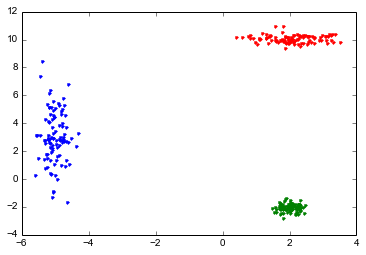

In [8]:
# generate gaussians
numGauss=3
gMix=list()
gMix.append(np.random.normal((-5,3),[0.25,2],(100,2)))
gMix.append(np.random.normal((2,-2),[0.25,0.25],(100,2)))
gMix.append(np.random.normal((2,10),[0.75,0.25],(100,2)))

mixture=np.concatenate(tuple(gMix))

# add outliers

# plot data points
for i in range(0,len(gMix)):
    plt.plot(gMix[i][:,0],gMix[i][:,1],'.')

## Initialization step
We start by creating several oracles (each representing a possible solution) and collapsing them into some values. The values to which the oracles collapsed are shown below. Each Oracle has $numClusters \times 2$ qubit strings since we're using two dimensional data. The length of the qubit strings specifies the magnitude to which the centroid values can go. In this example the data takes low values so we'll use only 5 bits, ranging the interval $[-16,16]$.

In [48]:
numClusters=7
numOracles=5
qubitStringLen=5

oras=list()
for i in range(0,5):
    oras.append(oracle.Oracle())
    oras[i].initialization(numClusters*2,qubitStringLen)
    oras[i].collapse()
    print "Oracle ",i
    print oras[i].getFloatArrays()
    print oras[i].getIntArrays()
    print oras[i].qstrings[0].binVal

Oracle  0
[None None None None None None None None None None None None None None]
[ -2  -5 -13 -12  13 -10  -2  -1  11  -9 -15  11   4  -5]
11110
Oracle  1
[None None None None None None None None None None None None None None]
[-14  -4  -1  -1   6  -9  -3  -3  -1  15  -3 -14   5  -5]
10010
Oracle  2
[None None None None None None None None None None None None None None]
[-13  -1   7  -3   5   0 -10 -13  -2  -5  -6   9 -11  -2]
10011
Oracle  3
[None None None None None None None None None None None None None None]
[ -9  -3  -1  -9  -9  -1  -1  -9  -9 -11  15  13  -9  -1]
10111
Oracle  4
[None None None None None None None None None None None None None None]
[ -1  -1 -15  -6  -6  -9 -15  -2  -5  -5 -13 -15  13 -12]
11111


## Clustering step
We know run the K-Means algoritmn for each oracle solution. We convert the Oracles' values to centroids and hand them over to the K-Means. Then we compute the Davies-Bouldin score on each Oracle and store it.

In [87]:
for i,ora in enumerate(oras):
    centroids = np.vstack(np.hsplit(ora.getIntArrays(),numClusters))
    estimator = KMeans(n_clusters=numClusters,init=centroids,n_init=1)
    assignment=estimator.fit_predict(mixture)
    centroids=estimator.cluster_centers_
    ora.setIntArrays(np.concatenate(centroids))
    print np.around(np.concatenate(centroids))[0],type(np.int(np.around(np.concatenate(centroids))[0]))
    
    score = DaviesBouldin.DaviesBouldin(mixture,centroids,assignment)
    ora.score=score.eval()
    print "Davies-Bouldin score of Oracle",i,"=",ora.score

3.0 <type 'int'>
Davies-Bouldin score of Oracle 0 = 39.9810939575
-5.0 <type 'int'>
Davies-Bouldin score of Oracle 1 = 22.9724276213
2.0 <type 'int'>
Davies-Bouldin score of Oracle 2 = 28.3490093139
1.0 <type 'int'>
Davies-Bouldin score of Oracle 3 = 31.1869869056
2.0 <type 'int'>
Davies-Bouldin score of Oracle 4 = 32.9003876142


## Quantum (Rotation) Gate step
With the first iteration performed, we compare all the oracles and keep only the best one. The others are subjected to a quantum rotation gate. The results below show the $\alpha$ and $\beta$ values of the qubits from the first qubit string of each oracle before and after the quantum rotation gate is applyed.

In [8]:
best=0
for i in range(1,numOracles):
    if oras[i].score<oras[i-1].score:
        best=i

print "Best oracle was ",best
        
for i in range(0,numOracles):
    if i == best:
        continue
    
    print "Oracle ",i
    qbString=list()
    for j in range(0,qubitStringLen):
        qbString.append([oras[i].qstrings[0].quString[j].alpha,oras[i].qstrings[0].quString[j].beta])
    print "Old qubit 1st string:\n",np.array(qbString)
    
    oras[i].QuantumGateStep(oras[best])
    
    qbString=list()
    for j in range(0,qubitStringLen):
        qbString.append([oras[i].qstrings[0].quString[j].alpha,oras[i].qstrings[0].quString[j].beta])
    print "New qubit 1st string:\n",np.array(qbString)
    

Best oracle was  3
Oracle  0
Old qubit 1st string:
[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
New qubit 1st string:
[[ 0.8293545   0.55872275]
 [ 0.70710678  0.70710678]
 [ 0.4075308   0.91319146]
 [ 0.52911616  0.8485494 ]
 [ 0.79570747  0.60568113]]
Oracle  1
Old qubit 1st string:
[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
New qubit 1st string:
[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.82237887  0.56894024]]
Oracle  2
Old qubit 1st string:
[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
New qubit 1st string:
[[ 0.79409362  0.60779546]
 [ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]
 [ 0.50572401  0.86269532]
 [ 0.70710678  0.70710678]]
Ora

# Automated Quantum (Genetic) K-Means

In [274]:
## Initialization  step
numClusters=5
numOracles=5
qubitStringLen=5
qGenerations=500

best=0 #index of best oracle (starts at 0)

oras=list()
centroids=[0]*numOracles
estimator=[0]*numOracles
assignment=[0]*numOracles

for i in range(0,numOracles):
    oras.append(oracle.Oracle())
    oras[i].initialization(numClusters*2,qubitStringLen)
    oras[i].collapse()

for qGen_ in range(0,qGenerations):
    ## Clustering step
    for i,ora in enumerate(oras):
        centroids[i] = np.vstack(np.hsplit(ora.getIntArrays(),numClusters))
        estimator[i] = KMeans(n_clusters=numClusters,init=centroids,n_init=1)
        assignment[i] = estimator.fit_predict(mixture)
        centroids[i] = estimator.cluster_centers_
    
    ## Compute fitness
        score = DaviesBouldin.DaviesBouldin(mixture,centroids,assignment)
        ora.score=score.eval()
    
    ## Store best from this generation
    for i in range(1,numOracles):
        if oras[i].score<oras[best].score:
            best=i
            
    ## Quantum Rotation Gate 
    for i in range(0,numOracles):
        if i == best:
            continue
        
        oras[i].QuantumGateStep(oras[best])
        
    ## Collapse qubits
        oras[i].collapse()
    """print "\n-------- It ",qGen_," ---------------"
    for i,ora in enumerate(oras):
        print "Score of Oracle",i," was ",ora.score"""
    print '.', # simple "progress bar"
        

for i in range(1,numOracles):
    if oras[i].score<oras[best].score:
        best=i
print "\n\nBest Oracle was ",best," with score ",oras[best].score
for i,ora in enumerate(oras):
    print "Score of Oracle",i," was ",ora.score
    


 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

In [51]:
for i in range(0,5):
    print oras[i].score
    
best=0
for i in range(1,numOracles):
    if oras[i].score<oras[best].score:
        best=i
        print i, oras[i].score, oras[i-1].score, best
        
print "\n\nBest Oracle was ",best," with score ",oras[best].score
print oras[3].score,oras[4].score

23.143089633
23.143089633
22.8047921824
38.7528696249
23.143089633
1 23.143089633 23.143089633 1
2 22.8047921824 23.143089633 2


Best Oracle was  2  with score  22.8047921824
38.7528696249 23.143089633


# Playing with numpy complex numbers

In [674]:
a=np.complex(np.random.rand(),np.random.rand())
b=np.complex(np.random.rand(),np.random.rand())
print "raw:",a,b

a=a/(np.sqrt(2)*np.abs(a))
b=b/(np.sqrt(2)*np.abs(b))
print "normalized:",a,b
print "|a|^2 + |b|^2=",pow(np.abs(a),2)+pow(np.abs(b),2)

np.arctan(1)

raw: (0.177353593511+0.450827989118j) (0.785741131715+0.392517725945j)
normalized: (0.258861992631+0.658020112741j) (0.632569114193+0.316000499635j)
|a|^2 + |b|^2= 1.0


0.78539816339744828

In [675]:
alpha=1/np.sqrt(2)
beta=1/np.sqrt(2)


qb=np.matrix([[alpha],[beta]])
angle=np.arctan(alpha / beta)

rot=np.matrix([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])

qb=rot*qb

alpha=qb.A1[0]
beta=qb.A1[0]

print alpha,beta


1.11022302463e-16 1.11022302463e-16


In [98]:
x=np.array([1.2,2.5,3.5])
x=np.around(x)
x=x.astype(int)
x

array([1, 2, 4])

In [15]:
from bitstring import BitArray

bar=BitArray(length=32)
bar.int=42
print bar.float
print int(bar.bin[0])+1,bar.bin[0]+1

TypeError: cannot concatenate 'str' and 'int' objects

5.88545355016e-44
1

In [16]:
x=np.linspace(-2*np.pi,2*np.pi,200)
y=np.arctan(x)
plt.plot(x,y)
plt.grid()
np.arctan(-np.inf)

NameError: name 'np' is not defined